In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# MNIST: Digits recognition with PyTorch 

All right, let's start then making sure we all know the basics! Let's recognize the ten handwritten digits learning from 60.000, 28x28 grayscale images.
For simplicity let's import a loading script we have already developed inside the **Continual AI Colab** repository:

In [3]:
from modules.data.mnist import init, load
init()

Files already downloaded!


In [4]:
x_train, t_train, x_test, t_test = load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


In [5]:
def episode_splits(train, test):
    splits = {label: [] for label in np.unique(test)}
    for img, label in tqdm(zip(train, test)):
        splits[label].append(img)
    return splits

train_set = episode_splits(x_train, t_train)
test_set = episode_splits(x_test, t_test)

60000it [00:00, 556939.75it/s]
10000it [00:00, 444585.02it/s]


Let's take a look at the actual images!

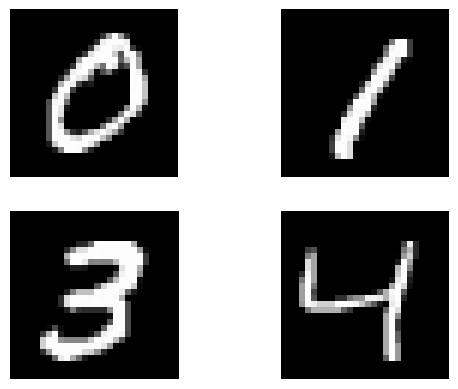

In [6]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(train_set[0][0][0], cmap="gray")
axarr[0,1].imshow(train_set[1][0][0], cmap="gray")
axarr[1,0].imshow(train_set[3][0][0], cmap="gray")
axarr[1,1].imshow(train_set[4][0][0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Good! Let's now set up a few general setting before using torch...

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1);

... and define our first conv-net! We will use 3 layers of convolutions and two fully connected layers:

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3)
        self.fc1 = nn.Linear(250, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 250)
        x = self.fc1(x)
        return x

In [9]:
import posteriors
import torchopt
from torch import func

model = Net().to(device)

print("Num params:", sum([p.numel() for p in model.parameters()]))

def log_posterior(num_data):
    def fn_call(params, batch):
        images, labels = batch
        output = func.functional_call(model, params, images)
        log_post_val = (
            -F.cross_entropy(output, labels)
            +  posteriors.diag_normal_log_prob(params) / num_data
        )
        return log_post_val, output
    return fn_call

Num params: 3020


In [10]:
def train_for_episode(params, optimizer, data, label, epochs=5, batch_size=100):
    state = optimizer.init(params)

    for _ in range(epochs):
        for i in range(0, len(data), batch_size):
            x = torch.stack([torch.from_numpy(p) for p in data[i:i+batch_size]])
            y = torch.ones((x.size(0),), dtype=torch.long) * label            
            state = optimizer.update(state, (x.to(device), y.to(device)), inplace=False)

    return state

@torch.inference_mode
def test_for_episode(params, data, label, batch_size=100):
    num_correct = 0
    for i in range(0, len(data), batch_size):
        x = torch.stack([torch.from_numpy(p) for p in data[i:i+batch_size]])
        outputs = func.functional_call(model, params, x.to(device))
        outputs = outputs.argmax(-1)
        num_correct += len(torch.where(outputs == label)[0])

    return num_correct / len(data)

episodes = list(train_set.keys())
test_metrics = []
params = dict(model.named_parameters())

for episode in tqdm(episodes): 
    label = episode
    episode_train_data = train_set[episode]
    optimizer = posteriors.torchopt.build(log_posterior(len(episode_train_data)), torchopt.adam(lr=1e-3, maximize=True))
    state = train_for_episode(params, optimizer, episode_train_data, label, epochs=1, batch_size=10)
    params = state.params

    step_i_test_metrics = {}
    for prev_episodes in episodes:
        episode_test_data = test_set[prev_episodes]
        accuracy = test_for_episode(params, episode_test_data, prev_episodes, batch_size=10)
        step_i_test_metrics[prev_episodes] = accuracy

    test_metrics.append(step_i_test_metrics)

100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


In [11]:
for i, metrics in enumerate(test_metrics):
    print(f"Episode {i}: {metrics}")

Episode 0: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
Episode 1: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
Episode 2: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
Episode 3: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
Episode 4: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
Episode 5: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 1.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
Episode 6: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 0.0, 9: 0.0}
Episode 7: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 1.0, 8: 0.0, 9: 0.0}
Episode 8: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 1.0, 9: 0.0}
Episode 9: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 1.0}
